## 1. libraries import and setup

In [1]:
from pathlib import Path
import importlib.util
import sys
import xarray as xr
import rioxarray as rxr
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import multiprocessing
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\DOPs
created directory data\raw_data\laz_ALS
created directory data\raw_data\laz_DAP
created directory data\raw_data\dtm_tiles
created directory data\raw_data\test_tiles
created directory data\processed_data\DOPs
created directory data\processed_data\nDSMs_ALS
created directory data\processed_data\nDSMs_DAP
created directory data\processed_data\laz_ALS
created directory data\processed_data\laz_DAP
created directory data\processed_data\datasets
created directory data\processed_data\models
created directory data\processed_data\gap_polygons_ALS
created directory data\processed_data\gap_polygons_DAP
created directory data\metadata
created directory src
created directory scripts
created directory output


## 2. data reading and preparation

In [3]:
# read preprocessed dataset (TDOP + nDSM for testing with gap mask)
test_ds = rxr.open_rasterio(processed_data_dir / 'datasets' / 'test_ds_tile1_lev0.tif',
                            band_as_variable=True)

# use the long_names as variable names 
# (previously assigned in script 'data_preparation')
for var_name in test_ds.data_vars:
    long_name = test_ds[var_name].attrs['long_name']
    test_ds = test_ds.rename({var_name: long_name})

test_ds

<xarray.Dataset>
Dimensions:      (x: 2000, y: 2000)
Coordinates:
  * x            (x) float64 5.43e+05 5.43e+05 5.43e+05 ... 5.44e+05 5.44e+05
  * y            (y) float64 5.738e+06 5.738e+06 ... 5.737e+06 5.737e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) float32 ...
    green        (y, x) float32 ...
    blue         (y, x) float32 ...
    nir          (y, x) float32 ...
    ndsm         (y, x) float32 ...
    gap_mask     (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area

In [4]:
# import data generator
src_dir = Path.cwd().parent / 'src'
sys.path.append(str(src_dir))
from cidg import CustomImageDataGenerator

# define tile size
tilesize = 224

# create an instance of the data generator
# hand over the test dataset (TDOP + nDSM with gap mask)
cidg_test = CustomImageDataGenerator(test_ds, tilesize, sampletype='test')

In [5]:
# get preprocessing of desired backbone
preprocess_input = sm.get_preprocessing('resnet34')

# preprocess input
cidg_test_preprocessed = preprocess_input(cidg_test)

## 3. model testing

In [6]:
# define custom objects
custom_objects = {
    'binary_crossentropy_plus_jaccard_loss': sm.losses.BinaryCELoss,
    'iou_score': sm.metrics.IOUScore(threshold=0.5),
    'f1-score': sm.metrics.FScore(threshold=0.5)
}

# load saved model (in script segmentation_models.ipynb)
model = tf.keras.models.load_model(processed_data_dir / 'models' / 'resnet34_unet_rgbi_ndsm',
                                   custom_objects=custom_objects)

In [7]:
# predict canopy gaps in the test area
prediction = model.predict(cidg_test_preprocessed, workers=multiprocessing.cpu_count() - 4)

8/8 [==============================] - 5s 418ms/step


In [8]:
print('number of tiles:', prediction.shape[0])
print('tilesize:', prediction.shape[1])
print('classes:', prediction.shape[3])

number of tiles: 64
tilesize: 224
classes: 1


In [9]:
# threshold the prediction to get a binary mask
threshold = 0.5
pred_mask = (prediction >= threshold).astype(int)
pred_mask = np.squeeze(pred_mask, axis=-1)

In [10]:
# merge all tiles into the original image
xs = test_ds.x.size - test_ds.x.size % tilesize
ys = test_ds.y.size - test_ds.y.size % tilesize

x_cnt = test_ds.x.size // tilesize
y_cnt = test_ds.y.size // tilesize

final_result = np.concatenate([np.concatenate(pred_mask[i*x_cnt:(i+1)*x_cnt], axis=1) for i in range(y_cnt)], axis=0)

In [39]:
# convert results into DataArray
final_result_converted = xr.DataArray(final_result,
                                      dims=test_ds.gap_mask[:-y_rest,:-x_rest].dims,
                                      coords=[test_ds.gap_mask[:-y_rest,:-x_rest].y, test_ds.gap_mask[:-y_rest,:-x_rest].x]
                                     ).astype(np.uint8)

# assign CRS
final_result_converted.rio.write_crs('epsg:25832', inplace=True)

# save the DataArray as GeoTif
final_result_converted.rio.to_raster(output_dir / 'prediction_tile1_lev0.tif')

In [57]:
# convert raster to polygons
shapes_gen = shapes(
    final_result_converted.values,
    mask=None,
    transform=final_result_converted.rio.transform()
    )

# convert the generator to a list of geometries and values
polygons = []
for geom, value in shapes_gen:
    if value == 1:
        polygons.append(shape(geom))

# create GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=final_result_converted.rio.crs)

# save polygons as Geopackage
gdf.to_file(output_dir / 'prediction_tile1_lev0.gpkg')

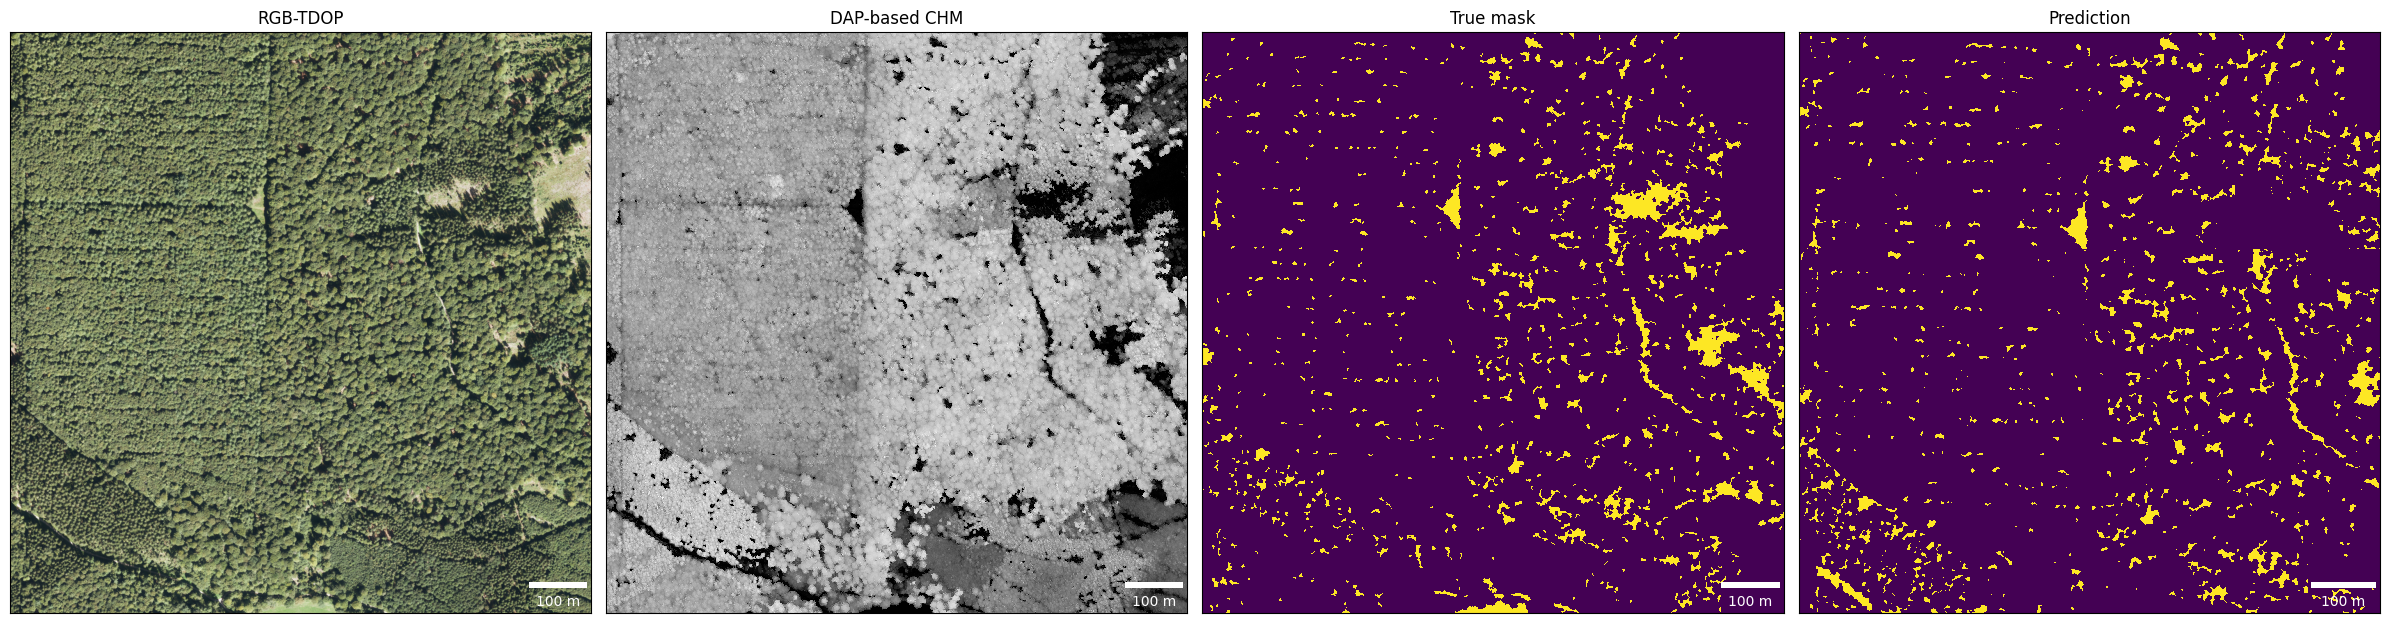

In [11]:
# plot final prediction
fig, ax = plt.subplots(1, 4, figsize=(24, 12))

# normalize the RGB bands to [0, 1] range
test_rgb_norm = np.stack([test_ds.red, test_ds.green, test_ds.blue]).transpose(1, 2, 0)
test_rgb_norm = (test_rgb_norm - test_rgb_norm.min()) / (test_rgb_norm.max() - test_rgb_norm.min())

# plot RGB-TDOP
im = ax[0].imshow(test_rgb_norm)
ax[0].set_title('RGB-TDOP')
ax[0].set_xticks([])
ax[0].set_yticks([])
scalebar = ScaleBar(dx=0.5, units="m", location='lower right', box_alpha=0, color='white', fixed_value=100)
ax[0].add_artist(scalebar)

# plot DAP-based CHM
ax[1].imshow(test_ds.ndsm, cmap='Greys_r', interpolation='None')
ax[1].set_title('DAP-based CHM')
ax[1].set_xticks([])
ax[1].set_yticks([])
scalebar = ScaleBar(dx=0.5, units="m", location='lower right', box_alpha=0, color='white', fixed_value=100)
ax[1].add_artist(scalebar)

# plot true mask
ax[2].imshow(np.where(test_ds.gap_mask == 1, 1, 0), interpolation='None')
ax[2].set_title('True mask')
ax[2].set_xticks([])
ax[2].set_yticks([])
scalebar = ScaleBar(dx=0.5, units="m", location='lower right', box_alpha=0, color='white', fixed_value=100)
ax[2].add_artist(scalebar)

# plot prediction
ax[3].imshow(final_result, interpolation='None')
ax[3].set_title('Prediction')
ax[3].set_xticks([])
ax[3].set_yticks([])
scalebar = ScaleBar(dx=0.5, units="m", location='lower right', box_alpha=0, color='white', fixed_value=100)
ax[3].add_artist(scalebar)

plt.tight_layout()
plt.show()

### error metrics

In [12]:
# calculate pixels that were not covered by complete tiles
y_rest = (test_ds.y.size % tilesize)
x_rest = (test_ds.x.size % tilesize)

In [13]:
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
iou.update_state(test_ds.gap_mask[:-y_rest,:-x_rest], final_result)
print("IoU for the canopy gap class:  {0:0.5f}".format(iou.result().numpy()))

mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(test_ds.gap_mask[:-y_rest,:-x_rest], final_result)
print("Mean IoU for both canopy gaps and non-canopy gaps:  {0:0.5f}".format(mean_iou.result().numpy()))

precision = tf.keras.metrics.Precision()
precision.update_state(test_ds.gap_mask[:-y_rest,:-x_rest], final_result)
print("Precision:  {0:0.5f}".format(precision.result().numpy()))

recall = tf.keras.metrics.Recall()
recall.update_state(test_ds.gap_mask[:-y_rest,:-x_rest], final_result)
print("Recall:  {0:0.5f}".format(recall.result().numpy()))

f1_score = 2 * ((precision.result().numpy() * recall.result().numpy() ) / (precision.result().numpy()  + recall.result().numpy() ))
print("F1-Score:  {0:0.5f}".format(f1_score))

IoU for the canopy gap class:  0.55578
Mean IoU for both canopy gaps and non-canopy gaps:  0.76027
Precision:  0.73029
Recall:  0.69932
F1-Score:  0.71447


### predicted gap area vs. true gap area

In [14]:
# align true mask to prediction size
true_mask = test_ds.gap_mask[:-y_rest, :-x_rest]
pred_mask = final_result

# get tile dimensions
height, width = pred_mask.shape

# get pixel resolution from test_ds
res_x = float(test_ds.x[1] - test_ds.x[0])
res_y = float(test_ds.y[0] - test_ds.y[1])

pixel_size = res_x 
pixel_area_m2 = pixel_size ** 2

# --- total tile area ---
total_tile_area_m2 = height * width * pixel_area_m2
total_tile_area_ha = total_tile_area_m2 / 10_000

# --- predicted gap area ---
tp = np.logical_and(pred_mask, true_mask)
fp = np.logical_and(pred_mask, np.logical_not(true_mask))

tp_count = np.sum(tp)
fp_count = np.sum(fp)
total_predicted_gap_pixels = tp_count + fp_count

tp_area_ha = (tp_count * pixel_area_m2) / 10_000
fp_area_ha = (fp_count * pixel_area_m2) / 10_000
total_pred_area_ha = (total_predicted_gap_pixels * pixel_area_m2) / 10_000

# --- true gap area (reference) ---
true_gap_count = np.sum(true_mask)
true_gap_area_ha = (true_gap_count * pixel_area_m2) / 10_000

# --- output ---
print(f"Total area of the tile:         {total_tile_area_ha:.2f} ha")
print(f"True gap area (reference):      {true_gap_area_ha:.1f} ha") 
print(f"Total predicted gap area:       {total_pred_area_ha:.1f} ha")
print(f"  └── True Positive gap area:   {tp_area_ha:.2f} ha")
print(f"  └── False Positive gap area:  {fp_area_ha:.2f} ha")
print(f"Predicted gap coverage:         {(total_pred_area_ha / total_tile_area_ha) * 100:.1f} %")
print(f"True gap coverage:              {(true_gap_area_ha / total_tile_area_ha) * 100:.1f} %")

Total area of the tile:         80.30 ha
True gap area (reference):      4.8 ha
Total predicted gap area:       4.6 ha
  └── True Positive gap area:   3.39 ha
  └── False Positive gap area:  1.25 ha
Predicted gap coverage:         5.8 %
True gap coverage:              6.0 %
